## Importing Libraries 

In [ ]:
import os
import math
import numpy as np
import pandas as pd
from typing import List, Dict, Any

# Gymnasium imports
import gymnasium as gym
from gymnasium import spaces

# Scikit-Learn
from sklearn.preprocessing import StandardScaler
# stable-baselines3 (PPO)
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback

import torch.nn as nn

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 120)

## Initiating Custom Gymnasium Env 

In [2]:
# INITIATE A CUSTOM GYMNASIUM ENVIRONMENT FOR HVAC (Valve control)

class HVACValveEnv(gym.Env):
    """Custom Gymnasium environment for HVAC Valve control.

    - Data-driven: uses a pandas DataFrame with features and a ground truth 'Valve' column.
    - Continuous action: single value in [0, 100].
    - Observation: numeric features vector for the current timestep.
    """

    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(
        self,
        df: pd.DataFrame,
        obs_cols: List[str],
        scaler: StandardScaler,
        episode_length: int = None,
        start_index: int = 0,
        smoothness_penalty_coef: float = 0.01,
        energy_penalty_coef: float = 0.001,
    ):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.obs_cols = obs_cols
        self.scaler = scaler
        self.episode_length = episode_length or len(df)
        self.start_index = start_index
        self.smoothness_penalty_coef = smoothness_penalty_coef
        self.energy_penalty_coef = energy_penalty_coef

        # Action space: single continuous action 0-100
        self.action_space = spaces.Box(low=0.0, high=100.0, shape=(1,), dtype=np.float32)

        # Observation space: shape = (n_features,) standardized
        obs_shape = (len(self.obs_cols),)
        # Use a wide box (standardized values can be outside -5..5), but SB3 works best with finite bounds
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=obs_shape, dtype=np.float32)

        # Internal pointers
        self.current_step = None
        self.episode_step = None
        self.last_action = None

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        # Option: choose a random start index so episodes cover different parts of data
        max_start = max(0, len(self.df) - self.episode_length)
        self.start_index = self.start_index if self.start_index <= max_start else np.random.randint(0, max_start + 1)
        self.current_step = self.start_index
        self.episode_step = 0
        self.last_action = np.array([50.0], dtype=np.float32)  # neutral starting valve

        obs = self._get_obs(self.current_step)
        return obs, {}

    def _get_obs(self, idx: int) -> np.ndarray:
        row = self.df.loc[idx, self.obs_cols].values.astype(float)
        row_scaled = self.scaler.transform(row.reshape(1, -1)).astype(np.float32).reshape(-1)
        return row_scaled

    def step(self, action: np.ndarray):
        # action is array-like of shape (1,)
        a = float(action[0])
        # clip into action space
        a = float(np.clip(a, self.action_space.low[0], self.action_space.high[0]))

        # Ground truth
        gt = float(self.df.loc[self.current_step, "Valve"])

        # Primary reward: negative absolute error (we want action close to gt)
        err = abs(a - gt)
        reward_primary = -err

        # Energy penalty: encourage lower ThermalEnergy when possible (we assume smaller valve -> less energy)
        if "ThermalEnergy" in self.df.columns:
            energy = float(self.df.loc[self.current_step, "ThermalEnergy"])
        else:
            energy = 0.0
        energy_penalty = - self.energy_penalty_coef * energy

        # Smoothness penalty: penalize large changes from last action
        smoothness_penalty = - self.smoothness_penalty_coef * abs(a - float(self.last_action))

        reward = reward_primary + energy_penalty + smoothness_penalty

        # record
        self.last_action = np.array([a], dtype=np.float32)

        # advance
        self.current_step += 1
        self.episode_step += 1

        # termination
        done = False
        if self.episode_step >= self.episode_length or self.current_step >= len(self.df):
            done = True

        obs = self._get_obs(self.current_step) if not done else np.zeros_like(self._get_obs(max(len(self.df)-1,0)))

        info = {"gt_valve": gt, "error": err, "energy": energy}

        return obs, float(reward), done, False, info

    def render(self, mode="human"):
        # optional: implement a simple print
        print(f"Step: {self.current_step}, Last action: {self.last_action}")

    def close(self):
        pass

## Initializing PPO model 

In [3]:
# Initialize PPO model (Stable-Baselines3)
# ---------------------------------------------------------------------------
# Will prepare data, scaler, and the wrapped environment for SB3. Then will create PPO.

# Load dataframe
feature_df = pd.read_csv("./files/final_feature_df.csv")
print("Loaded dataframe shape:", feature_df.shape)


# Choose observation columns: all numeric columns minus target and timestamp if present
exclude_cols = {"Valve", "ts"}

obs_cols = [
    "RaTemp", "SaTemp", "RaHumidity", "ThermEnergy",
    "main_temp", "main_humidity", "wind_speed", "clouds_all",
    "hour_sin", "hour_cos", "minute_sin", "minute_cos", "dayofweek", "is_weekend", "Occp",
    "delta_supply_return", "delta_outdoor_indoor", "delta_humidity","Valve_lag_1", "RaTemp_lag_1", "SaTemp_lag_1", 
    "RaHumidity_lag_1"
]

# Fill NA (simple strategy) and fit scaler
df_for_scaler = feature_df[obs_cols].fillna(method="ffill").fillna(0.0)
scaler = StandardScaler()
scaler.fit(df_for_scaler.values)

# Episode length: we can use sequential windows of fixed length for training
EPISODE_LENGTH = 256

# Create environment factory for DummyVecEnv
def make_env(start_index=0):
    def _init():
        env = HVACValveEnv(
            df=feature_df.fillna(method="ffill").fillna(0.0),
            obs_cols=obs_cols,
            scaler=scaler,
            episode_length=EPISODE_LENGTH,
            start_index=start_index,
            smoothness_penalty_coef=0.02,
            energy_penalty_coef=0.001,
        )
        return env
    return _init

# Vectorized environment (wrap with DummyVecEnv)
n_envs = 4
env_fns = [make_env(start_index=i * EPISODE_LENGTH) for i in range(n_envs)]
vec_env = DummyVecEnv(env_fns)

# Optional: use VecNormalize for more stable training
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

policy_kwargs = dict(
    activation_fn=nn.ReLU,
    net_arch=[dict(pi=[256, 128], vf=[256, 128])]
)
model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=2048 // n_envs,
    batch_size=64,
    policy_kwargs=policy_kwargs,
)

Loaded dataframe shape: (6201, 31)
Using cpu device


In [4]:
# obs_cols

## Training PPO Model 

In [5]:
# Train PPO model
# ---------------------------------------------------------------------------
# Comments: Creating a checkpoint callback to save models periodically and an EvalCallback
# to measure performance on a held-out slice

# Setup callbacks
checkpoint_callback = CheckpointCallback(save_freq=5000, save_path="./checkpoints/", name_prefix="ppo_hvac")

# Create eval env for callback (same wrapping as training)
eval_env = DummyVecEnv([make_env(start_index=max(0, n_envs * EPISODE_LENGTH - EPISODE_LENGTH))])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# Sync normalization stats
eval_env.obs_rms = vec_env.obs_rms

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./best_model/",
    n_eval_episodes=5,
    eval_freq=5000,
    deterministic=True
)

# Train
TOTAL_TIMESTEPS = 3000000
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=[checkpoint_callback, eval_callback])

# Save final model and VecNormalize statistics
os.makedirs("./models", exist_ok=True)
model.save("./models/ppo_hvac_final")
# Save VecNormalize
vec_env.save("./models/vec_normalize.pkl")

-----------------------------
| time/              |      |
|    fps             | 683  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 390          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0003489773 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.000119    |
|    learning_rate        | 0.0003       |
|    loss                 | 4.17e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00078     |
|    std                  | 0.998        |
|    value_loss           | 9.25e+05     |
----------------

-------------------------------------------
| time/                   |               |
|    fps                  | 333           |
|    iterations           | 12            |
|    time_elapsed         | 73            |
|    total_timesteps      | 24576         |
| train/                  |               |
|    approx_kl            | 5.0279486e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0.895         |
|    learning_rate        | 0.0003        |
|    loss                 | 8.58e+04      |
|    n_updates            | 110           |
|    policy_gradient_loss | -6.63e-05     |
|    std                  | 0.999         |
|    value_loss           | 2.96e+05      |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 333          |
|    iterations           | 13     

-------------------------------------------
| time/                   |               |
|    fps                  | 321           |
|    iterations           | 22            |
|    time_elapsed         | 140           |
|    total_timesteps      | 45056         |
| train/                  |               |
|    approx_kl            | 1.1624856e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.41         |
|    explained_variance   | 0.928         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.03e+05      |
|    n_updates            | 210           |
|    policy_gradient_loss | -8.84e-05     |
|    std                  | 0.993         |
|    value_loss           | 2.65e+05      |
-------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 321            |
|    iterations           | 2

------------------------------------------
| time/                   |              |
|    fps                  | 319          |
|    iterations           | 32           |
|    time_elapsed         | 205          |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 6.383023e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.951        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.01e+05     |
|    n_updates            | 310          |
|    policy_gradient_loss | -8.82e-05    |
|    std                  | 1            |
|    value_loss           | 1.98e+05     |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 320           |
|    iterations           | 33            |
|    ti

------------------------------------------
| time/                   |              |
|    fps                  | 318          |
|    iterations           | 42           |
|    time_elapsed         | 269          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 5.367241e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.967        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.27e+04     |
|    n_updates            | 410          |
|    policy_gradient_loss | -4.81e-05    |
|    std                  | 1            |
|    value_loss           | 1.37e+05     |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 318           |
|    iterations           | 43            |
|    ti

------------------------------------------
| time/                   |              |
|    fps                  | 315          |
|    iterations           | 52           |
|    time_elapsed         | 337          |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 3.842375e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.98         |
|    learning_rate        | 0.0003       |
|    loss                 | 2.02e+04     |
|    n_updates            | 510          |
|    policy_gradient_loss | -4.27e-05    |
|    std                  | 0.996        |
|    value_loss           | 8.91e+04     |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 315           |
|    iterations           | 53            |
|    ti

------------------------------------------
| time/                   |              |
|    fps                  | 312          |
|    iterations           | 62           |
|    time_elapsed         | 405          |
|    total_timesteps      | 126976       |
| train/                  |              |
|    approx_kl            | 3.115827e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.988        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.3e+04      |
|    n_updates            | 610          |
|    policy_gradient_loss | -4.15e-05    |
|    std                  | 1            |
|    value_loss           | 5.41e+04     |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 313           |
|    iterations           | 63            |
|    ti

--------------------------------------------
| time/                   |                |
|    fps                  | 316            |
|    iterations           | 72             |
|    time_elapsed         | 466            |
|    total_timesteps      | 147456         |
| train/                  |                |
|    approx_kl            | 0.000114822906 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -1.42          |
|    explained_variance   | 0.993          |
|    learning_rate        | 0.0003         |
|    loss                 | 1.51e+04       |
|    n_updates            | 710            |
|    policy_gradient_loss | -0.000195      |
|    std                  | 1              |
|    value_loss           | 3.05e+04       |
--------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 316            |
|    itera

-------------------------------------------
| time/                   |               |
|    fps                  | 314           |
|    iterations           | 82            |
|    time_elapsed         | 534           |
|    total_timesteps      | 167936        |
| train/                  |               |
|    approx_kl            | 0.00029030134 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0.996         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+04      |
|    n_updates            | 810           |
|    policy_gradient_loss | -0.000341     |
|    std                  | 0.998         |
|    value_loss           | 1.64e+04      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 314           |
|    iterations           | 83  

------------------------------------------
| time/                   |              |
|    fps                  | 315          |
|    iterations           | 92           |
|    time_elapsed         | 597          |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 5.670474e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.998        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.92e+03     |
|    n_updates            | 910          |
|    policy_gradient_loss | -0.000334    |
|    std                  | 0.99         |
|    value_loss           | 8.77e+03     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 314          |
|    iterations           | 93           |
|    time_e

-----------------------------------------
| time/                   |             |
|    fps                  | 314         |
|    iterations           | 102         |
|    time_elapsed         | 665         |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 9.34618e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.87e+03    |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.00031    |
|    std                  | 0.987       |
|    value_loss           | 4.77e+03    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 314          |
|    iterations           | 103          |
|    time_elapsed         | 67

------------------------------------------
| time/                   |              |
|    fps                  | 314          |
|    iterations           | 112          |
|    time_elapsed         | 729          |
|    total_timesteps      | 229376       |
| train/                  |              |
|    approx_kl            | 0.0005193994 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | 0.999        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.46e+03     |
|    n_updates            | 1110         |
|    policy_gradient_loss | -0.000893    |
|    std                  | 1.02         |
|    value_loss           | 2.68e+03     |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 314           |
|    iterations           | 113           |
|    ti

-------------------------------------------
| time/                   |               |
|    fps                  | 313           |
|    iterations           | 122           |
|    time_elapsed         | 797           |
|    total_timesteps      | 249856        |
| train/                  |               |
|    approx_kl            | 0.00031204193 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.44         |
|    explained_variance   | 1             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+03      |
|    n_updates            | 1210          |
|    policy_gradient_loss | -0.000337     |
|    std                  | 1.02          |
|    value_loss           | 1.63e+03      |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 312          |
|    iterations           | 123    

------------------------------------------
| time/                   |              |
|    fps                  | 312          |
|    iterations           | 132          |
|    time_elapsed         | 864          |
|    total_timesteps      | 270336       |
| train/                  |              |
|    approx_kl            | 8.845472e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 1            |
|    learning_rate        | 0.0003       |
|    loss                 | 489          |
|    n_updates            | 1310         |
|    policy_gradient_loss | -0.000306    |
|    std                  | 1            |
|    value_loss           | 1.1e+03      |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 312           |
|    iterations           | 133           |
|    ti

-------------------------------------------
| time/                   |               |
|    fps                  | 313           |
|    iterations           | 142           |
|    time_elapsed         | 926           |
|    total_timesteps      | 290816        |
| train/                  |               |
|    approx_kl            | 0.00068950566 |
|    clip_fraction        | 9.77e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.43         |
|    explained_variance   | 1             |
|    learning_rate        | 0.0003        |
|    loss                 | 320           |
|    n_updates            | 1410          |
|    policy_gradient_loss | -0.000863     |
|    std                  | 1.01          |
|    value_loss           | 781           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 313          |
|    iterations           | 143    

------------------------------------------
| time/                   |              |
|    fps                  | 314          |
|    iterations           | 152          |
|    time_elapsed         | 990          |
|    total_timesteps      | 311296       |
| train/                  |              |
|    approx_kl            | 0.0058562113 |
|    clip_fraction        | 0.0247       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 1            |
|    learning_rate        | 0.0003       |
|    loss                 | 136          |
|    n_updates            | 1510         |
|    policy_gradient_loss | -0.0043      |
|    std                  | 0.984        |
|    value_loss           | 562          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 314         |
|    iterations           | 153         |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 313         |
|    iterations           | 162         |
|    time_elapsed         | 1057        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.004910197 |
|    clip_fraction        | 0.044       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 376         |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.00565    |
|    std                  | 0.985       |
|    value_loss           | 411         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 313         |
|    iterations           | 163         |
|    time_elapsed         | 1063  

------------------------------------------
| time/                   |              |
|    fps                  | 313          |
|    iterations           | 172          |
|    time_elapsed         | 1123         |
|    total_timesteps      | 352256       |
| train/                  |              |
|    approx_kl            | 0.0057807756 |
|    clip_fraction        | 0.0521       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.33        |
|    explained_variance   | 1            |
|    learning_rate        | 0.0003       |
|    loss                 | 31.7         |
|    n_updates            | 1710         |
|    policy_gradient_loss | -0.00888     |
|    std                  | 0.909        |
|    value_loss           | 310          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 313        |
|    iterations           | 173        |
|    time_elapsed  

------------------------------------------
| time/                   |              |
|    fps                  | 313          |
|    iterations           | 182          |
|    time_elapsed         | 1189         |
|    total_timesteps      | 372736       |
| train/                  |              |
|    approx_kl            | 0.0062434236 |
|    clip_fraction        | 0.0531       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.28        |
|    explained_variance   | 1            |
|    learning_rate        | 0.0003       |
|    loss                 | 706          |
|    n_updates            | 1810         |
|    policy_gradient_loss | -0.00945     |
|    std                  | 0.866        |
|    value_loss           | 239          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 313         |
|    iterations           | 183         |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 312         |
|    iterations           | 192         |
|    time_elapsed         | 1256        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.006236179 |
|    clip_fraction        | 0.077       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.19       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 393         |
|    n_updates            | 1910        |
|    policy_gradient_loss | -0.0105     |
|    std                  | 0.795       |
|    value_loss           | 183         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 312          |
|    iterations           | 193          |
|    time_elapsed         | 12

-----------------------------------------
| time/                   |             |
|    fps                  | 312         |
|    iterations           | 202         |
|    time_elapsed         | 1323        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.009920839 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.12       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 34.9        |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.00674    |
|    std                  | 0.739       |
|    value_loss           | 156         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 312         |
|    iterations           | 203         |
|    time_elapsed         | 1330  

-----------------------------------------
| time/                   |             |
|    fps                  | 312         |
|    iterations           | 212         |
|    time_elapsed         | 1391        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.007038376 |
|    clip_fraction        | 0.0707      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 91.7        |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.0094     |
|    std                  | 0.69        |
|    value_loss           | 125         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 311          |
|    iterations           | 213          |
|    time_elapsed         | 13

-----------------------------------------
| time/                   |             |
|    fps                  | 310         |
|    iterations           | 222         |
|    time_elapsed         | 1463        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.013037203 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.953      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 45.9        |
|    n_updates            | 2210        |
|    policy_gradient_loss | -0.0122     |
|    std                  | 0.622       |
|    value_loss           | 102         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 310         |
|    iterations           | 223         |
|    time_elapsed         | 1469  

-----------------------------------------
| time/                   |             |
|    fps                  | 308         |
|    iterations           | 232         |
|    time_elapsed         | 1538        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.011527264 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.886      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 10.2        |
|    n_updates            | 2310        |
|    policy_gradient_loss | -0.0129     |
|    std                  | 0.584       |
|    value_loss           | 88.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 308         |
|    iterations           | 233         |
|    time_elapsed         | 1545  

-----------------------------------------
| time/                   |             |
|    fps                  | 307         |
|    iterations           | 242         |
|    time_elapsed         | 1611        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.009709388 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.832      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 97.6        |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.0123     |
|    std                  | 0.555       |
|    value_loss           | 77.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 307         |
|    iterations           | 243         |
|    time_elapsed         | 1618  

------------------------------------------
| time/                   |              |
|    fps                  | 307          |
|    iterations           | 252          |
|    time_elapsed         | 1676         |
|    total_timesteps      | 516096       |
| train/                  |              |
|    approx_kl            | 0.0122656915 |
|    clip_fraction        | 0.144        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.735       |
|    explained_variance   | 1            |
|    learning_rate        | 0.0003       |
|    loss                 | 14.8         |
|    n_updates            | 2510         |
|    policy_gradient_loss | -0.0115      |
|    std                  | 0.504        |
|    value_loss           | 66.7         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 307        |
|    iterations           | 253        |
|    time_elapsed  

-----------------------------------------
| time/                   |             |
|    fps                  | 308         |
|    iterations           | 262         |
|    time_elapsed         | 1739        |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.014180218 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.671      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 11.6        |
|    n_updates            | 2610        |
|    policy_gradient_loss | -0.0135     |
|    std                  | 0.47        |
|    value_loss           | 61.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 308         |
|    iterations           | 263         |
|    time_elapsed         | 1746  

----------------------------------------
| time/                   |            |
|    fps                  | 309        |
|    iterations           | 272        |
|    time_elapsed         | 1801       |
|    total_timesteps      | 557056     |
| train/                  |            |
|    approx_kl            | 0.01726607 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.618     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 69.1       |
|    n_updates            | 2710       |
|    policy_gradient_loss | -0.012     |
|    std                  | 0.448      |
|    value_loss           | 52.3       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 308         |
|    iterations           | 273         |
|    time_elapsed         | 1809        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 309         |
|    iterations           | 282         |
|    time_elapsed         | 1865        |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.016506217 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.538      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 27.8        |
|    n_updates            | 2810        |
|    policy_gradient_loss | -0.00969    |
|    std                  | 0.414       |
|    value_loss           | 49.9        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 309        |
|    iterations           | 283        |
|    time_elapsed         | 1871      

----------------------------------------
| time/                   |            |
|    fps                  | 310        |
|    iterations           | 292        |
|    time_elapsed         | 1928       |
|    total_timesteps      | 598016     |
| train/                  |            |
|    approx_kl            | 0.02138665 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.542     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 16         |
|    n_updates            | 2910       |
|    policy_gradient_loss | -0.0156    |
|    std                  | 0.416      |
|    value_loss           | 42         |
----------------------------------------
Eval num_timesteps=600000, episode_reward=-10313.08 +/- 0.26
Episode length: 256.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 256         |
| 

----------------------------------------
| time/                   |            |
|    fps                  | 310        |
|    iterations           | 302        |
|    time_elapsed         | 1992       |
|    total_timesteps      | 618496     |
| train/                  |            |
|    approx_kl            | 0.02022781 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.5       |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 5.88       |
|    n_updates            | 3010       |
|    policy_gradient_loss | -0.0127    |
|    std                  | 0.399      |
|    value_loss           | 35.3       |
----------------------------------------
Eval num_timesteps=620000, episode_reward=-10234.98 +/- 0.26
Episode length: 256.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 256        |
|    

Eval num_timesteps=640000, episode_reward=-10147.11 +/- 0.28
Episode length: 256.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 256         |
|    mean_reward          | -1.01e+04   |
| time/                   |             |
|    total_timesteps      | 640000      |
| train/                  |             |
|    approx_kl            | 0.028340358 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.443      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 11.8        |
|    n_updates            | 3120        |
|    policy_gradient_loss | -0.0118     |
|    std                  | 0.374       |
|    value_loss           | 33.2        |
-----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 

Eval num_timesteps=660000, episode_reward=-10099.65 +/- 0.27
Episode length: 256.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 256        |
|    mean_reward          | -1.01e+04  |
| time/                   |            |
|    total_timesteps      | 660000     |
| train/                  |            |
|    approx_kl            | 0.02793111 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.385     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.58       |
|    n_updates            | 3220       |
|    policy_gradient_loss | -0.0116    |
|    std                  | 0.356      |
|    value_loss           | 29.6       |
----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 309    |
|    itera

Eval num_timesteps=680000, episode_reward=-10015.86 +/- 0.27
Episode length: 256.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 256         |
|    mean_reward          | -1e+04      |
| time/                   |             |
|    total_timesteps      | 680000      |
| train/                  |             |
|    approx_kl            | 0.023201799 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.376      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 6.41        |
|    n_updates            | 3320        |
|    policy_gradient_loss | -0.0119     |
|    std                  | 0.353       |
|    value_loss           | 29.2        |
-----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 

New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 308    |
|    iterations      | 342    |
|    time_elapsed    | 2271   |
|    total_timesteps | 700416 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 308         |
|    iterations           | 343         |
|    time_elapsed         | 2278        |
|    total_timesteps      | 702464      |
| train/                  |             |
|    approx_kl            | 0.026654895 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.378      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 4.51        |
|    n_updates            | 3420        |
|    policy_gradient_loss | -0.00643    |
|    std                  | 0.355       |
|    value_loss           | 26          

New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 306    |
|    iterations      | 352    |
|    time_elapsed    | 2348   |
|    total_timesteps | 720896 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 306         |
|    iterations           | 353         |
|    time_elapsed         | 2354        |
|    total_timesteps      | 722944      |
| train/                  |             |
|    approx_kl            | 0.022400811 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.352      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 5.54        |
|    n_updates            | 3520        |
|    policy_gradient_loss | -0.0139     |
|    std                  | 0.344       |
|    value_loss           | 25.2        

New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 306    |
|    iterations      | 362    |
|    time_elapsed    | 2419   |
|    total_timesteps | 741376 |
-------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 306        |
|    iterations           | 363        |
|    time_elapsed         | 2426       |
|    total_timesteps      | 743424     |
| train/                  |            |
|    approx_kl            | 0.03500452 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.335     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 8.48       |
|    n_updates            | 3620       |
|    policy_gradient_loss | -0.00553   |
|    std                  | 0.339      |
|    value_loss           | 23.4       |
----------------

New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 305    |
|    iterations      | 372    |
|    time_elapsed    | 2493   |
|    total_timesteps | 761856 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 305         |
|    iterations           | 373         |
|    time_elapsed         | 2500        |
|    total_timesteps      | 763904      |
| train/                  |             |
|    approx_kl            | 0.025912898 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.33       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 17.1        |
|    n_updates            | 3720        |
|    policy_gradient_loss | -0.0101     |
|    std                  | 0.336       |
|    value_loss           | 21.2        

-----------------------------------------
| time/                   |             |
|    fps                  | 304         |
|    iterations           | 383         |
|    time_elapsed         | 2576        |
|    total_timesteps      | 784384      |
| train/                  |             |
|    approx_kl            | 0.037145518 |
|    clip_fraction        | 0.247       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.311      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 18          |
|    n_updates            | 3820        |
|    policy_gradient_loss | -0.0091     |
|    std                  | 0.331       |
|    value_loss           | 19.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 304        |
|    iterations           | 384        |
|    time_elapsed         | 2582      

-----------------------------------------
| time/                   |             |
|    fps                  | 303         |
|    iterations           | 393         |
|    time_elapsed         | 2651        |
|    total_timesteps      | 804864      |
| train/                  |             |
|    approx_kl            | 0.026469443 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.33       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 9.37        |
|    n_updates            | 3920        |
|    policy_gradient_loss | -0.00277    |
|    std                  | 0.338       |
|    value_loss           | 18.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 303         |
|    iterations           | 394         |
|    time_elapsed         | 2658  

-----------------------------------------
| time/                   |             |
|    fps                  | 302         |
|    iterations           | 403         |
|    time_elapsed         | 2724        |
|    total_timesteps      | 825344      |
| train/                  |             |
|    approx_kl            | 0.046252318 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.303      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 15.4        |
|    n_updates            | 4020        |
|    policy_gradient_loss | -0.0108     |
|    std                  | 0.327       |
|    value_loss           | 19.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 302        |
|    iterations           | 404        |
|    time_elapsed         | 2733      

----------------------------------------
| time/                   |            |
|    fps                  | 301        |
|    iterations           | 413        |
|    time_elapsed         | 2809       |
|    total_timesteps      | 845824     |
| train/                  |            |
|    approx_kl            | 0.79470605 |
|    clip_fraction        | 0.364      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.292     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.02       |
|    n_updates            | 4120       |
|    policy_gradient_loss | 0.00115    |
|    std                  | 0.323      |
|    value_loss           | 18.6       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 300        |
|    iterations           | 414        |
|    time_elapsed         | 2817       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 300        |
|    iterations           | 423        |
|    time_elapsed         | 2886       |
|    total_timesteps      | 866304     |
| train/                  |            |
|    approx_kl            | 0.10031845 |
|    clip_fraction        | 0.313      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.316     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 3.81       |
|    n_updates            | 4220       |
|    policy_gradient_loss | -0.00362   |
|    std                  | 0.334      |
|    value_loss           | 18.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 299         |
|    iterations           | 424         |
|    time_elapsed         | 2895        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 298         |
|    iterations           | 433         |
|    time_elapsed         | 2966        |
|    total_timesteps      | 886784      |
| train/                  |             |
|    approx_kl            | 0.047627345 |
|    clip_fraction        | 0.254       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.352      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 14.8        |
|    n_updates            | 4320        |
|    policy_gradient_loss | -0.00486    |
|    std                  | 0.344       |
|    value_loss           | 16.1        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 298        |
|    iterations           | 434        |
|    time_elapsed         | 2975      

-----------------------------------------
| time/                   |             |
|    fps                  | 296         |
|    iterations           | 443         |
|    time_elapsed         | 3064        |
|    total_timesteps      | 907264      |
| train/                  |             |
|    approx_kl            | 0.043217655 |
|    clip_fraction        | 0.271       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.386      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 7.66        |
|    n_updates            | 4420        |
|    policy_gradient_loss | 0.00124     |
|    std                  | 0.357       |
|    value_loss           | 17.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 295         |
|    iterations           | 444         |
|    time_elapsed         | 3074  

----------------------------------------
| time/                   |            |
|    fps                  | 295        |
|    iterations           | 453        |
|    time_elapsed         | 3144       |
|    total_timesteps      | 927744     |
| train/                  |            |
|    approx_kl            | 0.04111432 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.374     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.61       |
|    n_updates            | 4520       |
|    policy_gradient_loss | -0.00711   |
|    std                  | 0.353      |
|    value_loss           | 16.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 295         |
|    iterations           | 454         |
|    time_elapsed         | 3150        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 294         |
|    iterations           | 463         |
|    time_elapsed         | 3225        |
|    total_timesteps      | 948224      |
| train/                  |             |
|    approx_kl            | 0.036917213 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.404      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 15.6        |
|    n_updates            | 4620        |
|    policy_gradient_loss | -0.0124     |
|    std                  | 0.361       |
|    value_loss           | 17.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 293         |
|    iterations           | 464         |
|    time_elapsed         | 3232  

----------------------------------------
| time/                   |            |
|    fps                  | 293        |
|    iterations           | 473        |
|    time_elapsed         | 3303       |
|    total_timesteps      | 968704     |
| train/                  |            |
|    approx_kl            | 0.04330064 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.423     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.13       |
|    n_updates            | 4720       |
|    policy_gradient_loss | -0.0101    |
|    std                  | 0.369      |
|    value_loss           | 16.7       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 293        |
|    iterations           | 474        |
|    time_elapsed         | 3311       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 290         |
|    iterations           | 483         |
|    time_elapsed         | 3404        |
|    total_timesteps      | 989184      |
| train/                  |             |
|    approx_kl            | 0.027426204 |
|    clip_fraction        | 0.274       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.404      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 5.05        |
|    n_updates            | 4820        |
|    policy_gradient_loss | -0.00182    |
|    std                  | 0.361       |
|    value_loss           | 15.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 289         |
|    iterations           | 484         |
|    time_elapsed         | 3420  

-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 493         |
|    time_elapsed         | 3494        |
|    total_timesteps      | 1009664     |
| train/                  |             |
|    approx_kl            | 0.118947655 |
|    clip_fraction        | 0.341       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.426      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 6.89        |
|    n_updates            | 4920        |
|    policy_gradient_loss | 0.00677     |
|    std                  | 0.372       |
|    value_loss           | 15.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 494         |
|    time_elapsed         | 3502  

----------------------------------------
| time/                   |            |
|    fps                  | 288        |
|    iterations           | 503        |
|    time_elapsed         | 3567       |
|    total_timesteps      | 1030144    |
| train/                  |            |
|    approx_kl            | 0.75406194 |
|    clip_fraction        | 0.384      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.403     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 5.95       |
|    n_updates            | 5020       |
|    policy_gradient_loss | 0.00685    |
|    std                  | 0.362      |
|    value_loss           | 16.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 504         |
|    time_elapsed         | 3574        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 513         |
|    time_elapsed         | 3636        |
|    total_timesteps      | 1050624     |
| train/                  |             |
|    approx_kl            | 0.043427248 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.412      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 7.92        |
|    n_updates            | 5120        |
|    policy_gradient_loss | -0.00579    |
|    std                  | 0.365       |
|    value_loss           | 17          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 514         |
|    time_elapsed         | 3644  

-----------------------------------------
| time/                   |             |
|    fps                  | 287         |
|    iterations           | 523         |
|    time_elapsed         | 3730        |
|    total_timesteps      | 1071104     |
| train/                  |             |
|    approx_kl            | 0.049943887 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.424      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 5.37        |
|    n_updates            | 5220        |
|    policy_gradient_loss | 0.00362     |
|    std                  | 0.371       |
|    value_loss           | 18.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 524         |
|    time_elapsed         | 3739  

----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 533        |
|    time_elapsed         | 3815       |
|    total_timesteps      | 1091584    |
| train/                  |            |
|    approx_kl            | 0.02887899 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.446     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 8.59       |
|    n_updates            | 5320       |
|    policy_gradient_loss | 0.00747    |
|    std                  | 0.379      |
|    value_loss           | 38.7       |
----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 286       |
|    iterations           | 534       |
|    time_elapsed         | 3821      |
|    total_timesteps 

----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 543        |
|    time_elapsed         | 3896       |
|    total_timesteps      | 1112064    |
| train/                  |            |
|    approx_kl            | 0.14236116 |
|    clip_fraction        | 0.325      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.436     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 7.79       |
|    n_updates            | 5420       |
|    policy_gradient_loss | 0.00138    |
|    std                  | 0.374      |
|    value_loss           | 16.1       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 544        |
|    time_elapsed         | 3903       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 553         |
|    time_elapsed         | 3975        |
|    total_timesteps      | 1132544     |
| train/                  |             |
|    approx_kl            | 0.040630676 |
|    clip_fraction        | 0.278       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.469      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 6.2         |
|    n_updates            | 5520        |
|    policy_gradient_loss | -0.00178    |
|    std                  | 0.389       |
|    value_loss           | 17          |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 554        |
|    time_elapsed         | 3991      

----------------------------------------
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 563        |
|    time_elapsed         | 4076       |
|    total_timesteps      | 1153024    |
| train/                  |            |
|    approx_kl            | 0.15563616 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.504     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 9.87       |
|    n_updates            | 5620       |
|    policy_gradient_loss | 0.0044     |
|    std                  | 0.399      |
|    value_loss           | 19.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 564         |
|    time_elapsed         | 4085        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 573         |
|    time_elapsed         | 4153        |
|    total_timesteps      | 1173504     |
| train/                  |             |
|    approx_kl            | 0.052167796 |
|    clip_fraction        | 0.302       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.484      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 7.62        |
|    n_updates            | 5720        |
|    policy_gradient_loss | -0.0114     |
|    std                  | 0.393       |
|    value_loss           | 15.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 574        |
|    time_elapsed         | 4161      

-----------------------------------------
| time/                   |             |
|    fps                  | 281         |
|    iterations           | 583         |
|    time_elapsed         | 4237        |
|    total_timesteps      | 1193984     |
| train/                  |             |
|    approx_kl            | 0.048591882 |
|    clip_fraction        | 0.32        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.547      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 15          |
|    n_updates            | 5820        |
|    policy_gradient_loss | -0.00533    |
|    std                  | 0.42        |
|    value_loss           | 15          |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 281        |
|    iterations           | 584        |
|    time_elapsed         | 4246      

-----------------------------------------
| time/                   |             |
|    fps                  | 281         |
|    iterations           | 593         |
|    time_elapsed         | 4315        |
|    total_timesteps      | 1214464     |
| train/                  |             |
|    approx_kl            | 0.028194219 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.57       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 9.73        |
|    n_updates            | 5920        |
|    policy_gradient_loss | -0.00613    |
|    std                  | 0.429       |
|    value_loss           | 26.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 281         |
|    iterations           | 594         |
|    time_elapsed         | 4321  

---------------------------------------
| time/                   |           |
|    fps                  | 281       |
|    iterations           | 603       |
|    time_elapsed         | 4394      |
|    total_timesteps      | 1234944   |
| train/                  |           |
|    approx_kl            | 52.688683 |
|    clip_fraction        | 0.7       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.562    |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 3.93      |
|    n_updates            | 6020      |
|    policy_gradient_loss | 0.153     |
|    std                  | 0.426     |
|    value_loss           | 16.3      |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 281         |
|    iterations           | 604         |
|    time_elapsed         | 4400        |
|    total_timesteps      | 12

-----------------------------------------
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 613         |
|    time_elapsed         | 4469        |
|    total_timesteps      | 1255424     |
| train/                  |             |
|    approx_kl            | 0.027803347 |
|    clip_fraction        | 0.254       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.603      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 5.27        |
|    n_updates            | 6120        |
|    policy_gradient_loss | -0.00244    |
|    std                  | 0.442       |
|    value_loss           | 18.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 281        |
|    iterations           | 614        |
|    time_elapsed         | 4474      

-----------------------------------------
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 624         |
|    time_elapsed         | 4549        |
|    total_timesteps      | 1277952     |
| train/                  |             |
|    approx_kl            | 0.033515297 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.587      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 9.67        |
|    n_updates            | 6230        |
|    policy_gradient_loss | -0.00419    |
|    std                  | 0.435       |
|    value_loss           | 15.4        |
-----------------------------------------
Eval num_timesteps=1280000, episode_reward=-8025.34 +/- 0.20
Episode length: 256.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length      

-----------------------------------------
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 634         |
|    time_elapsed         | 4630        |
|    total_timesteps      | 1298432     |
| train/                  |             |
|    approx_kl            | 0.029896459 |
|    clip_fraction        | 0.261       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.563      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 11.6        |
|    n_updates            | 6330        |
|    policy_gradient_loss | -0.00985    |
|    std                  | 0.425       |
|    value_loss           | 15.9        |
-----------------------------------------
Eval num_timesteps=1300000, episode_reward=-7967.14 +/- 0.20
Episode length: 256.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length      

----------------------------------------
| time/                   |            |
|    fps                  | 280        |
|    iterations           | 644        |
|    time_elapsed         | 4698       |
|    total_timesteps      | 1318912    |
| train/                  |            |
|    approx_kl            | 0.05319918 |
|    clip_fraction        | 0.274      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.524     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.98       |
|    n_updates            | 6430       |
|    policy_gradient_loss | -0.00773   |
|    std                  | 0.41       |
|    value_loss           | 15.5       |
----------------------------------------
Eval num_timesteps=1320000, episode_reward=-7775.33 +/- 0.22
Episode length: 256.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 256        |
|    

Eval num_timesteps=1340000, episode_reward=-7750.45 +/- 0.21
Episode length: 256.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 256        |
|    mean_reward          | -7.75e+03  |
| time/                   |            |
|    total_timesteps      | 1340000    |
| train/                  |            |
|    approx_kl            | 0.36210907 |
|    clip_fraction        | 0.351      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.527     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 7.67       |
|    n_updates            | 6540       |
|    policy_gradient_loss | 2.77e-05   |
|    std                  | 0.412      |
|    value_loss           | 15.4       |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 280     |
|    it

Eval num_timesteps=1360000, episode_reward=-7583.64 +/- 0.22
Episode length: 256.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 256        |
|    mean_reward          | -7.58e+03  |
| time/                   |            |
|    total_timesteps      | 1360000    |
| train/                  |            |
|    approx_kl            | 0.08643778 |
|    clip_fraction        | 0.325      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.527     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 5.85       |
|    n_updates            | 6640       |
|    policy_gradient_loss | -0.0163    |
|    std                  | 0.411      |
|    value_loss           | 13.8       |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 280     |
|    it

--------------------------------
| time/              |         |
|    fps             | 279     |
|    iterations      | 674     |
|    time_elapsed    | 4930    |
|    total_timesteps | 1380352 |
--------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 279        |
|    iterations           | 675        |
|    time_elapsed         | 4938       |
|    total_timesteps      | 1382400    |
| train/                  |            |
|    approx_kl            | 0.06567215 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.554     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.92       |
|    n_updates            | 6740       |
|    policy_gradient_loss | -0.00583   |
|    std                  | 0.422      |
|    value_loss           | 12.9       |
-------------------------------

New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 279     |
|    iterations      | 684     |
|    time_elapsed    | 5012    |
|    total_timesteps | 1400832 |
--------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 279        |
|    iterations           | 685        |
|    time_elapsed         | 5020       |
|    total_timesteps      | 1402880    |
| train/                  |            |
|    approx_kl            | 0.04142184 |
|    clip_fraction        | 0.304      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.553     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 8.33       |
|    n_updates            | 6840       |
|    policy_gradient_loss | -0.00486   |
|    std                  | 0.421      |
|    value_loss           | 14.6       |
---------

---------------------------------------
| time/                   |           |
|    fps                  | 279       |
|    iterations           | 695       |
|    time_elapsed         | 5101      |
|    total_timesteps      | 1423360   |
| train/                  |           |
|    approx_kl            | 3.1109242 |
|    clip_fraction        | 0.407     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.497    |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 4.51      |
|    n_updates            | 6940      |
|    policy_gradient_loss | 0.00643   |
|    std                  | 0.396     |
|    value_loss           | 19.1      |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 278       |
|    iterations           | 696       |
|    time_elapsed         | 5109      |
|    total_timesteps      | 1425408   |


-----------------------------------------
| time/                   |             |
|    fps                  | 278         |
|    iterations           | 706         |
|    time_elapsed         | 5196        |
|    total_timesteps      | 1445888     |
| train/                  |             |
|    approx_kl            | 0.028196473 |
|    clip_fraction        | 0.252       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.476      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 5.57        |
|    n_updates            | 7050        |
|    policy_gradient_loss | -0.00641    |
|    std                  | 0.388       |
|    value_loss           | 15.3        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 278        |
|    iterations           | 707        |
|    time_elapsed         | 5205      

---------------------------------------
| time/                   |           |
|    fps                  | 276       |
|    iterations           | 717       |
|    time_elapsed         | 5312      |
|    total_timesteps      | 1468416   |
| train/                  |           |
|    approx_kl            | 0.2770613 |
|    clip_fraction        | 0.354     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.43     |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 5.65      |
|    n_updates            | 7160      |
|    policy_gradient_loss | -0.00409  |
|    std                  | 0.372     |
|    value_loss           | 13.2      |
---------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 276        |
|    iterations           | 718        |
|    time_elapsed         | 5320       |
|    total_timesteps      | 1470464

----------------------------------------
| time/                   |            |
|    fps                  | 275        |
|    iterations           | 728        |
|    time_elapsed         | 5421       |
|    total_timesteps      | 1490944    |
| train/                  |            |
|    approx_kl            | 0.03416633 |
|    clip_fraction        | 0.285      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.437     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.31       |
|    n_updates            | 7270       |
|    policy_gradient_loss | -0.00807   |
|    std                  | 0.374      |
|    value_loss           | 15.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 274         |
|    iterations           | 729         |
|    time_elapsed         | 5430        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 274        |
|    iterations           | 739        |
|    time_elapsed         | 5512       |
|    total_timesteps      | 1513472    |
| train/                  |            |
|    approx_kl            | 0.06464347 |
|    clip_fraction        | 0.274      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.492     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.02       |
|    n_updates            | 7380       |
|    policy_gradient_loss | -0.00788   |
|    std                  | 0.394      |
|    value_loss           | 15.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 274         |
|    iterations           | 740         |
|    time_elapsed         | 5519        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 274        |
|    iterations           | 750        |
|    time_elapsed         | 5597       |
|    total_timesteps      | 1536000    |
| train/                  |            |
|    approx_kl            | 0.13602771 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.442     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 7.16       |
|    n_updates            | 7490       |
|    policy_gradient_loss | -0.00178   |
|    std                  | 0.375      |
|    value_loss           | 15         |
----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 274       |
|    iterations           | 751       |
|    time_elapsed         | 5605      |
|    total_timesteps 

----------------------------------------
| time/                   |            |
|    fps                  | 274        |
|    iterations           | 761        |
|    time_elapsed         | 5673       |
|    total_timesteps      | 1558528    |
| train/                  |            |
|    approx_kl            | 0.07412322 |
|    clip_fraction        | 0.368      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.418     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 7.46       |
|    n_updates            | 7600       |
|    policy_gradient_loss | 0.00685    |
|    std                  | 0.367      |
|    value_loss           | 14.8       |
----------------------------------------
Eval num_timesteps=1560000, episode_reward=-7374.21 +/- 0.10
Episode length: 256.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 256       |
|    mea

Eval num_timesteps=1580000, episode_reward=-7189.44 +/- 0.11
Episode length: 256.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 256         |
|    mean_reward          | -7.19e+03   |
| time/                   |             |
|    total_timesteps      | 1580000     |
| train/                  |             |
|    approx_kl            | 0.062276762 |
|    clip_fraction        | 0.339       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.412      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 6.49        |
|    n_updates            | 7710        |
|    policy_gradient_loss | -0.00497    |
|    std                  | 0.364       |
|    value_loss           | 14          |
-----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             

New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 273     |
|    iterations      | 782     |
|    time_elapsed    | 5845    |
|    total_timesteps | 1601536 |
--------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 273       |
|    iterations           | 783       |
|    time_elapsed         | 5852      |
|    total_timesteps      | 1603584   |
| train/                  |           |
|    approx_kl            | 0.2408639 |
|    clip_fraction        | 0.343     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.408    |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 7.42      |
|    n_updates            | 7820      |
|    policy_gradient_loss | -0.00415  |
|    std                  | 0.361     |
|    value_loss           | 14.1      |
---------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 273        |
|    iterations           | 793        |
|    time_elapsed         | 5936       |
|    total_timesteps      | 1624064    |
| train/                  |            |
|    approx_kl            | 0.10362385 |
|    clip_fraction        | 0.351      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.454     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 3.44       |
|    n_updates            | 7920       |
|    policy_gradient_loss | 0.0127     |
|    std                  | 0.382      |
|    value_loss           | 13.5       |
----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 273       |
|    iterations           | 794       |
|    time_elapsed         | 5944      |
|    total_timesteps 

----------------------------------------
| time/                   |            |
|    fps                  | 273        |
|    iterations           | 804        |
|    time_elapsed         | 6022       |
|    total_timesteps      | 1646592    |
| train/                  |            |
|    approx_kl            | 0.12301089 |
|    clip_fraction        | 0.393      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.459     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 4.71       |
|    n_updates            | 8030       |
|    policy_gradient_loss | 0.0202     |
|    std                  | 0.385      |
|    value_loss           | 17.4       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 273        |
|    iterations           | 805        |
|    time_elapsed         | 6035       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 271        |
|    iterations           | 815        |
|    time_elapsed         | 6153       |
|    total_timesteps      | 1669120    |
| train/                  |            |
|    approx_kl            | 0.03476845 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.508     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 3.7        |
|    n_updates            | 8140       |
|    policy_gradient_loss | -8.72e-05  |
|    std                  | 0.405      |
|    value_loss           | 12.4       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 271        |
|    iterations           | 816        |
|    time_elapsed         | 6159       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 269        |
|    iterations           | 826        |
|    time_elapsed         | 6272       |
|    total_timesteps      | 1691648    |
| train/                  |            |
|    approx_kl            | 0.05051908 |
|    clip_fraction        | 0.356      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.512     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 7.99       |
|    n_updates            | 8250       |
|    policy_gradient_loss | 0.0121     |
|    std                  | 0.404      |
|    value_loss           | 15.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 269         |
|    iterations           | 827         |
|    time_elapsed         | 6280        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 268        |
|    iterations           | 837        |
|    time_elapsed         | 6381       |
|    total_timesteps      | 1714176    |
| train/                  |            |
|    approx_kl            | 0.06880654 |
|    clip_fraction        | 0.285      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.568     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 5.42       |
|    n_updates            | 8360       |
|    policy_gradient_loss | -0.00631   |
|    std                  | 0.429      |
|    value_loss           | 15.4       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 268        |
|    iterations           | 838        |
|    time_elapsed         | 6388       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 267        |
|    iterations           | 848        |
|    time_elapsed         | 6483       |
|    total_timesteps      | 1736704    |
| train/                  |            |
|    approx_kl            | 0.04679752 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.611     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 7.64       |
|    n_updates            | 8470       |
|    policy_gradient_loss | -0.00383   |
|    std                  | 0.445      |
|    value_loss           | 14.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 267         |
|    iterations           | 849         |
|    time_elapsed         | 6491        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 266         |
|    iterations           | 859         |
|    time_elapsed         | 6600        |
|    total_timesteps      | 1759232     |
| train/                  |             |
|    approx_kl            | 0.042639542 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.656      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 4.23        |
|    n_updates            | 8580        |
|    policy_gradient_loss | 0.00151     |
|    std                  | 0.468       |
|    value_loss           | 27          |
-----------------------------------------
Eval num_timesteps=1760000, episode_reward=-6146.82 +/- 0.08
Episode length: 256.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length      

Eval num_timesteps=1780000, episode_reward=-6162.64 +/- 0.11
Episode length: 256.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 256       |
|    mean_reward          | -6.16e+03 |
| time/                   |           |
|    total_timesteps      | 1780000   |
| train/                  |           |
|    approx_kl            | 9.418514  |
|    clip_fraction        | 0.498     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.689    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.2       |
|    n_updates            | 8690      |
|    policy_gradient_loss | 0.0109    |
|    std                  | 0.48      |
|    value_loss           | 110       |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 266     |
|    iterations      | 870     |
|    time_elaps

---------------------------------------
| time/                   |           |
|    fps                  | 265       |
|    iterations           | 880       |
|    time_elapsed         | 6782      |
|    total_timesteps      | 1802240   |
| train/                  |           |
|    approx_kl            | 0.8265794 |
|    clip_fraction        | 0.428     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.671    |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 8.45      |
|    n_updates            | 8790      |
|    policy_gradient_loss | -0.00242  |
|    std                  | 0.471     |
|    value_loss           | 16.6      |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 265         |
|    iterations           | 881         |
|    time_elapsed         | 6789        |
|    total_timesteps      | 18

----------------------------------------
| time/                   |            |
|    fps                  | 264        |
|    iterations           | 891        |
|    time_elapsed         | 6888       |
|    total_timesteps      | 1824768    |
| train/                  |            |
|    approx_kl            | 0.04435393 |
|    clip_fraction        | 0.301      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.674     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 2.55       |
|    n_updates            | 8900       |
|    policy_gradient_loss | -0.000857  |
|    std                  | 0.476      |
|    value_loss           | 15.4       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 264         |
|    iterations           | 892         |
|    time_elapsed         | 6897        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 263         |
|    iterations           | 902         |
|    time_elapsed         | 7008        |
|    total_timesteps      | 1847296     |
| train/                  |             |
|    approx_kl            | 0.021025524 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.737      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.5        |
|    n_updates            | 9010        |
|    policy_gradient_loss | -0.0132     |
|    std                  | 0.505       |
|    value_loss           | 79.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 263        |
|    iterations           | 903        |
|    time_elapsed         | 7018      

---------------------------------------
| time/                   |           |
|    fps                  | 263       |
|    iterations           | 913       |
|    time_elapsed         | 7102      |
|    total_timesteps      | 1869824   |
| train/                  |           |
|    approx_kl            | 0.0811316 |
|    clip_fraction        | 0.31      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.767    |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 9.96      |
|    n_updates            | 9120      |
|    policy_gradient_loss | -0.0139   |
|    std                  | 0.521     |
|    value_loss           | 17.4      |
---------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 263        |
|    iterations           | 914        |
|    time_elapsed         | 7110       |
|    total_timesteps      | 1871872

-----------------------------------------
| time/                   |             |
|    fps                  | 262         |
|    iterations           | 924         |
|    time_elapsed         | 7200        |
|    total_timesteps      | 1892352     |
| train/                  |             |
|    approx_kl            | 0.043571144 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 8.82        |
|    n_updates            | 9230        |
|    policy_gradient_loss | -0.00243    |
|    std                  | 0.477       |
|    value_loss           | 18.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 262         |
|    iterations           | 925         |
|    time_elapsed         | 7206  

-----------------------------------------
| time/                   |             |
|    fps                  | 263         |
|    iterations           | 934         |
|    time_elapsed         | 7272        |
|    total_timesteps      | 1912832     |
| train/                  |             |
|    approx_kl            | 0.048946768 |
|    clip_fraction        | 0.321       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.674      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 5.98        |
|    n_updates            | 9330        |
|    policy_gradient_loss | 0.0068      |
|    std                  | 0.479       |
|    value_loss           | 15.1        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 263        |
|    iterations           | 935        |
|    time_elapsed         | 7279      

----------------------------------------
| time/                   |            |
|    fps                  | 263        |
|    iterations           | 945        |
|    time_elapsed         | 7358       |
|    total_timesteps      | 1935360    |
| train/                  |            |
|    approx_kl            | 0.05765426 |
|    clip_fraction        | 0.279      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.688     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 9.14       |
|    n_updates            | 9440       |
|    policy_gradient_loss | -0.00629   |
|    std                  | 0.482      |
|    value_loss           | 15.9       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 263        |
|    iterations           | 946        |
|    time_elapsed         | 7364       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 262        |
|    iterations           | 956        |
|    time_elapsed         | 7446       |
|    total_timesteps      | 1957888    |
| train/                  |            |
|    approx_kl            | 0.20283006 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.73      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 3.23       |
|    n_updates            | 9550       |
|    policy_gradient_loss | -0.00949   |
|    std                  | 0.499      |
|    value_loss           | 14.4       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 262        |
|    iterations           | 957        |
|    time_elapsed         | 7453       |
|    total_times

Eval num_timesteps=1980000, episode_reward=-5427.45 +/- 0.10
Episode length: 256.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 256        |
|    mean_reward          | -5.43e+03  |
| time/                   |            |
|    total_timesteps      | 1980000    |
| train/                  |            |
|    approx_kl            | 0.06351883 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.701     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 5.4        |
|    n_updates            | 9660       |
|    policy_gradient_loss | -0.00531   |
|    std                  | 0.488      |
|    value_loss           | 14.3       |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 262     |
|    it

Eval num_timesteps=2000000, episode_reward=-5267.83 +/- 0.09
Episode length: 256.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 256         |
|    mean_reward          | -5.27e+03   |
| time/                   |             |
|    total_timesteps      | 2000000     |
| train/                  |             |
|    approx_kl            | 0.035948724 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.693      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 8.27        |
|    n_updates            | 9760        |
|    policy_gradient_loss | -0.00726    |
|    std                  | 0.48        |
|    value_loss           | 15.3        |
-----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             

Eval num_timesteps=2020000, episode_reward=-5121.62 +/- 0.09
Episode length: 256.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 256         |
|    mean_reward          | -5.12e+03   |
| time/                   |             |
|    total_timesteps      | 2020000     |
| train/                  |             |
|    approx_kl            | 0.053965874 |
|    clip_fraction        | 0.343       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.718      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 10.9        |
|    n_updates            | 9860        |
|    policy_gradient_loss | -0.00695    |
|    std                  | 0.496       |
|    value_loss           | 14.5        |
-----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             

--------------------------------
| time/              |         |
|    fps             | 260     |
|    iterations      | 997     |
|    time_elapsed    | 7829    |
|    total_timesteps | 2041856 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 998         |
|    time_elapsed         | 7842        |
|    total_timesteps      | 2043904     |
| train/                  |             |
|    approx_kl            | 0.026477389 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.717      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 8.92        |
|    n_updates            | 9970        |
|    policy_gradient_loss | -0.00473    |
|    std                  | 0.498       |
|    value_loss           | 36.9        |
-------------

----------------------------------------
| time/                   |            |
|    fps                  | 260        |
|    iterations           | 1008       |
|    time_elapsed         | 7934       |
|    total_timesteps      | 2064384    |
| train/                  |            |
|    approx_kl            | 0.04673528 |
|    clip_fraction        | 0.31       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.765     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 7.74       |
|    n_updates            | 10070      |
|    policy_gradient_loss | -0.00378   |
|    std                  | 0.521      |
|    value_loss           | 13.2       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 260        |
|    iterations           | 1009       |
|    time_elapsed         | 7944       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 259        |
|    iterations           | 1018       |
|    time_elapsed         | 8024       |
|    total_timesteps      | 2084864    |
| train/                  |            |
|    approx_kl            | 0.13633172 |
|    clip_fraction        | 0.319      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.79      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.1        |
|    n_updates            | 10170      |
|    policy_gradient_loss | 0.00747    |
|    std                  | 0.535      |
|    value_loss           | 17.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 259         |
|    iterations           | 1019        |
|    time_elapsed         | 8032        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 259        |
|    iterations           | 1028       |
|    time_elapsed         | 8106       |
|    total_timesteps      | 2105344    |
| train/                  |            |
|    approx_kl            | 0.06893736 |
|    clip_fraction        | 0.301      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.8       |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 4.19       |
|    n_updates            | 10270      |
|    policy_gradient_loss | -0.00324   |
|    std                  | 0.539      |
|    value_loss           | 13.7       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 259        |
|    iterations           | 1029       |
|    time_elapsed         | 8112       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 259        |
|    iterations           | 1039       |
|    time_elapsed         | 8199       |
|    total_timesteps      | 2127872    |
| train/                  |            |
|    approx_kl            | 0.03496489 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.823     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.06       |
|    n_updates            | 10380      |
|    policy_gradient_loss | -0.0151    |
|    std                  | 0.551      |
|    value_loss           | 14.5       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 259        |
|    iterations           | 1040       |
|    time_elapsed         | 8206       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 259         |
|    iterations           | 1049        |
|    time_elapsed         | 8287        |
|    total_timesteps      | 2148352     |
| train/                  |             |
|    approx_kl            | 0.040315412 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.813      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 8.25        |
|    n_updates            | 10480       |
|    policy_gradient_loss | -0.0125     |
|    std                  | 0.547       |
|    value_loss           | 13.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 259         |
|    iterations           | 1050        |
|    time_elapsed         | 8292  

----------------------------------------
| time/                   |            |
|    fps                  | 259        |
|    iterations           | 1059       |
|    time_elapsed         | 8360       |
|    total_timesteps      | 2168832    |
| train/                  |            |
|    approx_kl            | 0.04546706 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.858     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 3.03       |
|    n_updates            | 10580      |
|    policy_gradient_loss | -0.0163    |
|    std                  | 0.573      |
|    value_loss           | 12.3       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 259        |
|    iterations           | 1060       |
|    time_elapsed         | 8368       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 259        |
|    iterations           | 1069       |
|    time_elapsed         | 8444       |
|    total_timesteps      | 2189312    |
| train/                  |            |
|    approx_kl            | 0.07931092 |
|    clip_fraction        | 0.348      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.877     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 10.6       |
|    n_updates            | 10680      |
|    policy_gradient_loss | -0.00621   |
|    std                  | 0.58       |
|    value_loss           | 12.4       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 259         |
|    iterations           | 1070        |
|    time_elapsed         | 8454        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 259        |
|    iterations           | 1080       |
|    time_elapsed         | 8535       |
|    total_timesteps      | 2211840    |
| train/                  |            |
|    approx_kl            | 0.06221633 |
|    clip_fraction        | 0.298      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.871     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 5.27       |
|    n_updates            | 10790      |
|    policy_gradient_loss | -0.0106    |
|    std                  | 0.58       |
|    value_loss           | 13.3       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 259        |
|    iterations           | 1081       |
|    time_elapsed         | 8543       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 258         |
|    iterations           | 1091        |
|    time_elapsed         | 8640        |
|    total_timesteps      | 2234368     |
| train/                  |             |
|    approx_kl            | 0.056706186 |
|    clip_fraction        | 0.303       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.925      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 4.39        |
|    n_updates            | 10900       |
|    policy_gradient_loss | -0.0121     |
|    std                  | 0.613       |
|    value_loss           | 13.1        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 258        |
|    iterations           | 1092       |
|    time_elapsed         | 8646      

-----------------------------------------
| time/                   |             |
|    fps                  | 258         |
|    iterations           | 1101        |
|    time_elapsed         | 8717        |
|    total_timesteps      | 2254848     |
| train/                  |             |
|    approx_kl            | 0.058342244 |
|    clip_fraction        | 0.311       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.954      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 4.57        |
|    n_updates            | 11000       |
|    policy_gradient_loss | -0.0102     |
|    std                  | 0.63        |
|    value_loss           | 13.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 258         |
|    iterations           | 1102        |
|    time_elapsed         | 8724  

----------------------------------------
| time/                   |            |
|    fps                  | 258        |
|    iterations           | 1112       |
|    time_elapsed         | 8802       |
|    total_timesteps      | 2277376    |
| train/                  |            |
|    approx_kl            | 0.15089016 |
|    clip_fraction        | 0.336      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.985     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.85       |
|    n_updates            | 11110      |
|    policy_gradient_loss | -0.00511   |
|    std                  | 0.646      |
|    value_loss           | 13.8       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 258        |
|    iterations           | 1113       |
|    time_elapsed         | 8811       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 258        |
|    iterations           | 1122       |
|    time_elapsed         | 8881       |
|    total_timesteps      | 2297856    |
| train/                  |            |
|    approx_kl            | 0.27497572 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.02      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 12.2       |
|    n_updates            | 11210      |
|    policy_gradient_loss | 0.00958    |
|    std                  | 0.671      |
|    value_loss           | 22         |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 258        |
|    iterations           | 1123       |
|    time_elapsed         | 8887       |
|    total_times

Eval num_timesteps=2320000, episode_reward=-3589.17 +/- 0.02
Episode length: 256.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 256        |
|    mean_reward          | -3.59e+03  |
| time/                   |            |
|    total_timesteps      | 2320000    |
| train/                  |            |
|    approx_kl            | 0.06622428 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.02      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 4.57       |
|    n_updates            | 11320      |
|    policy_gradient_loss | 0.00334    |
|    std                  | 0.668      |
|    value_loss           | 13.7       |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 259     |
|    iterations      | 1133  

Eval num_timesteps=2340000, episode_reward=-3378.44 +/- 0.02
Episode length: 256.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 256         |
|    mean_reward          | -3.38e+03   |
| time/                   |             |
|    total_timesteps      | 2340000     |
| train/                  |             |
|    approx_kl            | 0.037623234 |
|    clip_fraction        | 0.317       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.02       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 5.7         |
|    n_updates            | 11420       |
|    policy_gradient_loss | -0.0114     |
|    std                  | 0.67        |
|    value_loss           | 12.1        |
-----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             

Eval num_timesteps=2360000, episode_reward=-3795.41 +/- 0.04
Episode length: 256.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 256        |
|    mean_reward          | -3.8e+03   |
| time/                   |            |
|    total_timesteps      | 2360000    |
| train/                  |            |
|    approx_kl            | 0.02708553 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.05      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 4.77       |
|    n_updates            | 11520      |
|    policy_gradient_loss | -0.0129    |
|    std                  | 0.687      |
|    value_loss           | 13.2       |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 259     |
|    iterations      | 1153  

Eval num_timesteps=2380000, episode_reward=-3609.88 +/- 0.03
Episode length: 256.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 256        |
|    mean_reward          | -3.61e+03  |
| time/                   |            |
|    total_timesteps      | 2380000    |
| train/                  |            |
|    approx_kl            | 0.04306068 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.03      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 7.48       |
|    n_updates            | 11620      |
|    policy_gradient_loss | -0.0134    |
|    std                  | 0.673      |
|    value_loss           | 13.9       |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 259     |
|    iterations      | 1163  

New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 259     |
|    iterations      | 1172    |
|    time_elapsed    | 9240    |
|    total_timesteps | 2400256 |
--------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 259        |
|    iterations           | 1173       |
|    time_elapsed         | 9248       |
|    total_timesteps      | 2402304    |
| train/                  |            |
|    approx_kl            | 0.07406117 |
|    clip_fraction        | 0.348      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.952     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 3.97       |
|    n_updates            | 11720      |
|    policy_gradient_loss | -0.00348   |
|    std                  | 0.624      |
|    value_loss           | 12.4       |
---------

---------------------------------------
| time/                   |           |
|    fps                  | 260       |
|    iterations           | 1183      |
|    time_elapsed         | 9318      |
|    total_timesteps      | 2422784   |
| train/                  |           |
|    approx_kl            | 0.0694721 |
|    clip_fraction        | 0.325     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.951    |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 11.4      |
|    n_updates            | 11820     |
|    policy_gradient_loss | 0.0225    |
|    std                  | 0.633     |
|    value_loss           | 17.6      |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 1184        |
|    time_elapsed         | 9325        |
|    total_timesteps      | 24

-----------------------------------------
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 1194        |
|    time_elapsed         | 9402        |
|    total_timesteps      | 2445312     |
| train/                  |             |
|    approx_kl            | 0.043468565 |
|    clip_fraction        | 0.291       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.94       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 7.81        |
|    n_updates            | 11930       |
|    policy_gradient_loss | 0.00105     |
|    std                  | 0.619       |
|    value_loss           | 29.5        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 260        |
|    iterations           | 1195       |
|    time_elapsed         | 9408      

----------------------------------------
| time/                   |            |
|    fps                  | 260        |
|    iterations           | 1204       |
|    time_elapsed         | 9479       |
|    total_timesteps      | 2465792    |
| train/                  |            |
|    approx_kl            | 0.05351222 |
|    clip_fraction        | 0.279      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.01      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 4.58       |
|    n_updates            | 12030      |
|    policy_gradient_loss | -0.0087    |
|    std                  | 0.665      |
|    value_loss           | 16         |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 260        |
|    iterations           | 1205       |
|    time_elapsed         | 9484       |
|    total_times

---------------------------------------
| time/                   |           |
|    fps                  | 260       |
|    iterations           | 1215      |
|    time_elapsed         | 9564      |
|    total_timesteps      | 2488320   |
| train/                  |           |
|    approx_kl            | 0.0804985 |
|    clip_fraction        | 0.254     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.01     |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 14.2      |
|    n_updates            | 12140     |
|    policy_gradient_loss | 0.00441   |
|    std                  | 0.661     |
|    value_loss           | 53.4      |
---------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 260        |
|    iterations           | 1216       |
|    time_elapsed         | 9573       |
|    total_timesteps      | 2490368

----------------------------------------
| time/                   |            |
|    fps                  | 260        |
|    iterations           | 1225       |
|    time_elapsed         | 9640       |
|    total_timesteps      | 2508800    |
| train/                  |            |
|    approx_kl            | 0.17747548 |
|    clip_fraction        | 0.35       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.06      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 4.95       |
|    n_updates            | 12240      |
|    policy_gradient_loss | 0.00474    |
|    std                  | 0.704      |
|    value_loss           | 13.3       |
----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 260       |
|    iterations           | 1226      |
|    time_elapsed         | 9648      |
|    total_timesteps 

-----------------------------------------
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 1236        |
|    time_elapsed         | 9722        |
|    total_timesteps      | 2531328     |
| train/                  |             |
|    approx_kl            | 0.053031582 |
|    clip_fraction        | 0.333       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 3.59        |
|    n_updates            | 12350       |
|    policy_gradient_loss | -0.00838    |
|    std                  | 0.725       |
|    value_loss           | 13.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 1237        |
|    time_elapsed         | 9730  

----------------------------------------
| time/                   |            |
|    fps                  | 260        |
|    iterations           | 1247       |
|    time_elapsed         | 9808       |
|    total_timesteps      | 2553856    |
| train/                  |            |
|    approx_kl            | 0.03963674 |
|    clip_fraction        | 0.296      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.15      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 7.02       |
|    n_updates            | 12460      |
|    policy_gradient_loss | -0.00168   |
|    std                  | 0.763      |
|    value_loss           | 13.4       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 260        |
|    iterations           | 1248       |
|    time_elapsed         | 9816       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 1257        |
|    time_elapsed         | 9881        |
|    total_timesteps      | 2574336     |
| train/                  |             |
|    approx_kl            | 0.026175587 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.16       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.9        |
|    n_updates            | 12560       |
|    policy_gradient_loss | -0.00126    |
|    std                  | 0.777       |
|    value_loss           | 80.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 1258        |
|    time_elapsed         | 9887  

-----------------------------------------
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 1267        |
|    time_elapsed         | 9959        |
|    total_timesteps      | 2594816     |
| train/                  |             |
|    approx_kl            | 0.048493773 |
|    clip_fraction        | 0.304       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.15       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 5.52        |
|    n_updates            | 12660       |
|    policy_gradient_loss | -0.0174     |
|    std                  | 0.76        |
|    value_loss           | 13.1        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 260        |
|    iterations           | 1268       |
|    time_elapsed         | 9964      

---------------------------------------
| time/                   |           |
|    fps                  | 260       |
|    iterations           | 1277      |
|    time_elapsed         | 10052     |
|    total_timesteps      | 2615296   |
| train/                  |           |
|    approx_kl            | 0.0435789 |
|    clip_fraction        | 0.265     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.15     |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 4.37      |
|    n_updates            | 12760     |
|    policy_gradient_loss | -0.016    |
|    std                  | 0.771     |
|    value_loss           | 13.4      |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 1278        |
|    time_elapsed         | 10059       |
|    total_timesteps      | 26

-----------------------------------------
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 1288        |
|    time_elapsed         | 10144       |
|    total_timesteps      | 2637824     |
| train/                  |             |
|    approx_kl            | 0.047451228 |
|    clip_fraction        | 0.274       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.17       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 9.79        |
|    n_updates            | 12870       |
|    policy_gradient_loss | -0.00594    |
|    std                  | 0.781       |
|    value_loss           | 22.9        |
-----------------------------------------
--------------------------------------
| time/                   |          |
|    fps                  | 260      |
|    iterations           | 1289     |
|    time_elapsed         | 10153    |
|    to

Eval num_timesteps=2660000, episode_reward=-1577.10 +/- 0.03
Episode length: 256.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 256        |
|    mean_reward          | -1.58e+03  |
| time/                   |            |
|    total_timesteps      | 2660000    |
| train/                  |            |
|    approx_kl            | 0.04802121 |
|    clip_fraction        | 0.335      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.15      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.09       |
|    n_updates            | 12980      |
|    policy_gradient_loss | -0.00935   |
|    std                  | 0.76       |
|    value_loss           | 12.7       |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 259     |
|    iterations      | 1299  

--------------------------------
| time/              |         |
|    fps             | 258     |
|    iterations      | 1309    |
|    time_elapsed    | 10369   |
|    total_timesteps | 2680832 |
--------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 258        |
|    iterations           | 1310       |
|    time_elapsed         | 10377      |
|    total_timesteps      | 2682880    |
| train/                  |            |
|    approx_kl            | 0.12707454 |
|    clip_fraction        | 0.355      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.15      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.15       |
|    n_updates            | 13090      |
|    policy_gradient_loss | -0.013     |
|    std                  | 0.768      |
|    value_loss           | 11.4       |
-------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 257        |
|    iterations           | 1320       |
|    time_elapsed         | 10511      |
|    total_timesteps      | 2703360    |
| train/                  |            |
|    approx_kl            | 0.05929076 |
|    clip_fraction        | 0.355      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.15      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 4.02       |
|    n_updates            | 13190      |
|    policy_gradient_loss | 0.00781    |
|    std                  | 0.77       |
|    value_loss           | 12.5       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 256         |
|    iterations           | 1321        |
|    time_elapsed         | 10529       |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 255        |
|    iterations           | 1330       |
|    time_elapsed         | 10644      |
|    total_timesteps      | 2723840    |
| train/                  |            |
|    approx_kl            | 0.21073776 |
|    clip_fraction        | 0.316      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.15      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 3.73       |
|    n_updates            | 13290      |
|    policy_gradient_loss | -0.00768   |
|    std                  | 0.766      |
|    value_loss           | 11.3       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 255         |
|    iterations           | 1331        |
|    time_elapsed         | 10658       |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 254        |
|    iterations           | 1340       |
|    time_elapsed         | 10791      |
|    total_timesteps      | 2744320    |
| train/                  |            |
|    approx_kl            | 0.14157422 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.14      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 4.45       |
|    n_updates            | 13390      |
|    policy_gradient_loss | 0.00166    |
|    std                  | 0.753      |
|    value_loss           | 11.7       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 254        |
|    iterations           | 1341       |
|    time_elapsed         | 10804      |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 253         |
|    iterations           | 1351        |
|    time_elapsed         | 10922       |
|    total_timesteps      | 2766848     |
| train/                  |             |
|    approx_kl            | 0.023127101 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.13       |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.6        |
|    n_updates            | 13500       |
|    policy_gradient_loss | -0.00154    |
|    std                  | 0.753       |
|    value_loss           | 185         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 253         |
|    iterations           | 1352        |
|    time_elapsed         | 10932 

----------------------------------------
| time/                   |            |
|    fps                  | 252        |
|    iterations           | 1362       |
|    time_elapsed         | 11048      |
|    total_timesteps      | 2789376    |
| train/                  |            |
|    approx_kl            | 0.04293552 |
|    clip_fraction        | 0.31       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.22      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 11         |
|    n_updates            | 13610      |
|    policy_gradient_loss | -0.0065    |
|    std                  | 0.827      |
|    value_loss           | 14.4       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 252         |
|    iterations           | 1363        |
|    time_elapsed         | 11058       |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 251         |
|    iterations           | 1373        |
|    time_elapsed         | 11177       |
|    total_timesteps      | 2811904     |
| train/                  |             |
|    approx_kl            | 0.049277335 |
|    clip_fraction        | 0.297       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 6.02        |
|    n_updates            | 13720       |
|    policy_gradient_loss | -0.00259    |
|    std                  | 0.823       |
|    value_loss           | 15.9        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 251        |
|    iterations           | 1374       |
|    time_elapsed         | 11186     

---------------------------------------
| time/                   |           |
|    fps                  | 251       |
|    iterations           | 1384      |
|    time_elapsed         | 11291     |
|    total_timesteps      | 2834432   |
| train/                  |           |
|    approx_kl            | 1.3847796 |
|    clip_fraction        | 0.455     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.24     |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 10.5      |
|    n_updates            | 13830     |
|    policy_gradient_loss | 0.00396   |
|    std                  | 0.834     |
|    value_loss           | 11.5      |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 251       |
|    iterations           | 1385      |
|    time_elapsed         | 11298     |
|    total_timesteps      | 2836480   |


-----------------------------------------
| time/                   |             |
|    fps                  | 251         |
|    iterations           | 1395        |
|    time_elapsed         | 11380       |
|    total_timesteps      | 2856960     |
| train/                  |             |
|    approx_kl            | 0.047088124 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.25       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 12.2        |
|    n_updates            | 13940       |
|    policy_gradient_loss | -0.00967    |
|    std                  | 0.841       |
|    value_loss           | 12.9        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 251        |
|    iterations           | 1396       |
|    time_elapsed         | 11387     

-----------------------------------------
| time/                   |             |
|    fps                  | 250         |
|    iterations           | 1406        |
|    time_elapsed         | 11474       |
|    total_timesteps      | 2879488     |
| train/                  |             |
|    approx_kl            | 0.040559582 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.25       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.38        |
|    n_updates            | 14050       |
|    policy_gradient_loss | -0.00623    |
|    std                  | 0.84        |
|    value_loss           | 25.1        |
-----------------------------------------
Eval num_timesteps=2880000, episode_reward=-1350.39 +/- 0.04
Episode length: 256.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 2

Eval num_timesteps=2900000, episode_reward=-1505.52 +/- 0.04
Episode length: 256.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 256         |
|    mean_reward          | -1.51e+03   |
| time/                   |             |
|    total_timesteps      | 2900000     |
| train/                  |             |
|    approx_kl            | 0.046447482 |
|    clip_fraction        | 0.295       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.66        |
|    n_updates            | 14160       |
|    policy_gradient_loss | -0.00431    |
|    std                  | 0.854       |
|    value_loss           | 20.6        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 250     |
|    itera

--------------------------------
| time/              |         |
|    fps             | 250     |
|    iterations      | 1426    |
|    time_elapsed    | 11681   |
|    total_timesteps | 2920448 |
--------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 249       |
|    iterations           | 1427      |
|    time_elapsed         | 11690     |
|    total_timesteps      | 2922496   |
| train/                  |           |
|    approx_kl            | 0.0781568 |
|    clip_fraction        | 0.372     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.26     |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 5.36      |
|    n_updates            | 14260     |
|    policy_gradient_loss | -0.00931  |
|    std                  | 0.859     |
|    value_loss           | 10.8      |
---------------------------------------
---------

---------------------------------------
| time/                   |           |
|    fps                  | 249       |
|    iterations           | 1437      |
|    time_elapsed         | 11805     |
|    total_timesteps      | 2942976   |
| train/                  |           |
|    approx_kl            | 13.207733 |
|    clip_fraction        | 0.651     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.27     |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 4.14      |
|    n_updates            | 14360     |
|    policy_gradient_loss | 0.1       |
|    std                  | 0.866     |
|    value_loss           | 10.6      |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 249         |
|    iterations           | 1438        |
|    time_elapsed         | 11813       |
|    total_timesteps      | 29

----------------------------------------
| time/                   |            |
|    fps                  | 249        |
|    iterations           | 1448       |
|    time_elapsed         | 11902      |
|    total_timesteps      | 2965504    |
| train/                  |            |
|    approx_kl            | 0.05524773 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.32      |
|    explained_variance   | 1          |
|    learning_rate        | 0.0003     |
|    loss                 | 5.79       |
|    n_updates            | 14470      |
|    policy_gradient_loss | -0.000546  |
|    std                  | 0.899      |
|    value_loss           | 11.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 249         |
|    iterations           | 1449        |
|    time_elapsed         | 11910       |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 249         |
|    iterations           | 1459        |
|    time_elapsed         | 11996       |
|    total_timesteps      | 2988032     |
| train/                  |             |
|    approx_kl            | 0.062930785 |
|    clip_fraction        | 0.342       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.32       |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | 6.66        |
|    n_updates            | 14580       |
|    policy_gradient_loss | 0.00642     |
|    std                  | 0.908       |
|    value_loss           | 12.8        |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 249       |
|    iterations           | 1460      |
|    time_elapsed         | 12005     |
| 

In [8]:
# Evaluate PPO performance
# For evaluation, use an un-normalized instance of the environment and manually apply scaler
eval_df = feature_df.copy().fillna(method="ffill").fillna(0.0)
start_eval = 0
end_eval = min(2000, len(eval_df) - 1)
eval_episode_length = end_eval - start_eval

eval_env_simple = HVACValveEnv(df=eval_df, obs_cols=obs_cols, scaler=scaler, episode_length=eval_episode_length, start_index=start_eval)
obs, _ = eval_env_simple.reset()

pred_actions = []
true_vals = []
infos = []

done = False
while not done:
    # SB3 models expect actions in their raw range; since our action space is [0,100], model will output that.
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = eval_env_simple.step(action)
    pred_actions.append(float(action[0]))
    true_vals.append(float(info.get("gt_valve", np.nan)))
    infos.append(info)


## Ploting

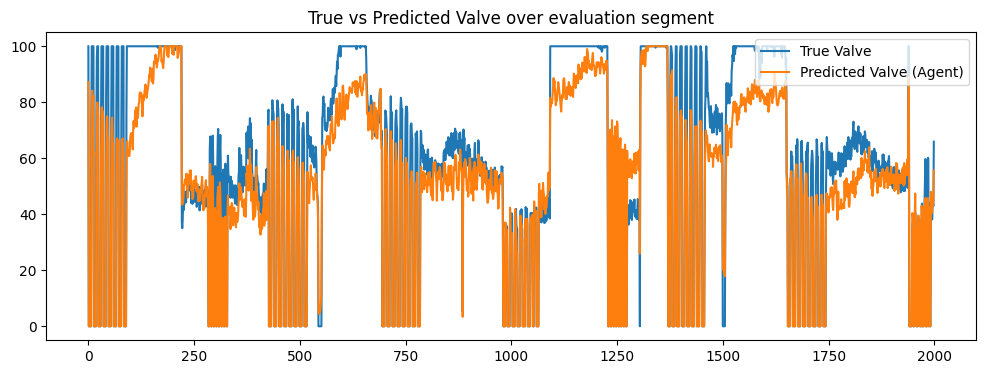

In [9]:
# Plot true vs predicted
plt.figure(figsize=(12, 4))
plt.plot(true_vals, label="True Valve")
plt.plot(pred_actions, label="Predicted Valve (Agent)")
plt.legend()
plt.title("True vs Predicted Valve over evaluation segment")
plt.show()

In [10]:
# Save evaluation results
eval_res = pd.DataFrame({"true_valve": true_vals, "pred_valve": pred_actions})
eval_res.to_csv("./models/evaluation_results.csv", index=False)

## Evaluation Metrics

In [11]:
# Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(true_vals, pred_actions)
mae = mean_absolute_error(true_vals, pred_actions)
print(f"Evaluation MSE: {mse:.4f}, MAE: {mae:.4f}")

Evaluation MSE: 143.4836, MAE: 8.7695


## END